# BLG 407 - Makine Öğrenmesi
## 2. Proje Ödevi: YOLOv8 ile Nesne Tespiti

---

| Bilgi | Değer |
|-------|-------|
| **Ad** | Halil İbrahim |
| **Soyad** | Balık |
| **Okul Numarası** | 2212721046 |
| **GitHub Repo** | https://github.com/halilbalik/YoloV8_Nesne_Tespiti |
| **Konu** | Saat ve Cüzdan Nesne Tespiti |

---

### Proje Özeti

Bu projede, kendi oluşturduğum görüntü veri seti üzerinde **YOLOv8** modeli eğitilmiş ve **PyQt5** tabanlı masaüstü uygulaması geliştirilmiştir.

**Veri Seti:** Roboflow ile etiketlenmiş 209 görüntü (saat ve cüzdan sınıfları)

---
## 1. Giriş ve Amaç

### YOLOv8 Nedir?

YOLO (You Only Look Once), gerçek zamanlı nesne tespiti için kullanılan state-of-the-art bir deep learning mimarisidir. YOLOv8, Ultralytics tarafından geliştirilen en güncel versiyondur.

### Proje Hedefleri:

1. Özgün veri seti ile YOLOv8 modeli eğitmek
2. Eğitim metriklerini (mAP, loss) analiz etmek
3. PyQt5 ile kullanıcı dostu GUI geliştirmek

### Veri Seti Bilgileri:

| Özellik | Değer |
|---------|-------|
| Sınıf Sayısı | 2 |
| Sınıflar | cuzdan, saat |
| Toplam Görüntü | 209 |
| Etiketleme Aracı | Roboflow |
| Format | YOLOv8 (txt) |

---
## 2. Kurulum ve Kütüphaneler

In [5]:
# YOLOv8 (Ultralytics) kurulumu
!pip install ultralytics -q

import os
import shutil
import zipfile
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display

from ultralytics import YOLO
from google.colab import drive

print("Kurulum tamamlandı!")
print(f"Tarih: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Kurulum tamamlandı!
Tarih: 2025-12-23 23:01


---
## 3. Veri Seti Yükleme

In [4]:
# Google Drive bağlantısı
drive.mount('/content/drive')

# Veri seti zip dosyasının yolu
# NOT: Roboflow'dan indirdiğiniz zip dosyasını Drive'a yükleyin
zip_path = '/content/drive/MyDrive/dataset_yolo.zip'

# Çıkarma dizini
extract_path = '/content/dataset'

# ZIP dosyasını çıkar
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Veri seti yüklendi!")
print(f"Konum: {extract_path}")

Mounted at /content/drive
Veri seti yüklendi!
Konum: /content/dataset


In [6]:
# Klasör yapısını kontrol et
print("KLASÖR YAPISI:")
print("="*50)

for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}📁 {os.path.basename(root)}/')

    # Sadece ilk 2 seviye ve dosya sayısını göster
    if level < 2:
        subindent = ' ' * 2 * (level + 1)
        for d in dirs:
            print(f'{subindent}📁 {d}/')
        if files:
            img_count = len([f for f in files if f.endswith(('.jpg', '.png', '.jpeg'))])
            txt_count = len([f for f in files if f.endswith('.txt')])
            if img_count > 0:
                print(f'{subindent}🖼️ {img_count} görüntü')
            if txt_count > 0:
                print(f'{subindent}📄 {txt_count} etiket dosyası')

KLASÖR YAPISI:
📁 dataset/
  📁 train/
  📁 valid/
  📁 test/
  📄 2 etiket dosyası
  📁 train/
    📁 labels/
    📁 images/
    📁 labels/
    📁 images/
  📁 valid/
    📁 labels/
    📁 images/
    📁 labels/
    📁 images/
  📁 test/
    📁 labels/
    📁 images/
    📁 labels/
    📁 images/


In [7]:
# data.yaml dosyasını kontrol et ve yolları güncelle
import yaml

# data.yaml'ın konumunu bul
yaml_path = None
for root, dirs, files in os.walk(extract_path):
    if 'data.yaml' in files:
        yaml_path = os.path.join(root, 'data.yaml')
        break

if yaml_path:
    print(f"data.yaml bulundu: {yaml_path}")

    # İçeriği oku
    with open(yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)

    print("\nMevcut içerik:")
    print(data_config)

    # Yolları güncelle (Colab için)
    base_path = os.path.dirname(yaml_path)

    data_config['train'] = os.path.join(base_path, 'train', 'images')
    data_config['val'] = os.path.join(base_path, 'valid', 'images')
    data_config['test'] = os.path.join(base_path, 'test', 'images')

    # Güncellenmiş config'i kaydet
    with open(yaml_path, 'w') as f:
        yaml.dump(data_config, f, default_flow_style=False)

    print("\n✅ Güncellenmiş yollar:")
    print(f"Train: {data_config['train']}")
    print(f"Val: {data_config['val']}")
    print(f"Test: {data_config['test']}")
    print(f"\nSınıflar ({data_config['nc']}): {data_config['names']}")
else:
    print("❌ data.yaml bulunamadı!")

data.yaml bulundu: /content/dataset/data.yaml

Mevcut içerik:
{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 2, 'names': ['cuzdan', 'saat'], 'roboflow': {'workspace': 'makineogrenmesi2', 'project': 'my-first-project-mi4qb', 'version': 1, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/makineogrenmesi2/my-first-project-mi4qb/dataset/1'}}

✅ Güncellenmiş yollar:
Train: /content/dataset/train/images
Val: /content/dataset/valid/images
Test: /content/dataset/test/images

Sınıflar (2): ['cuzdan', 'saat']


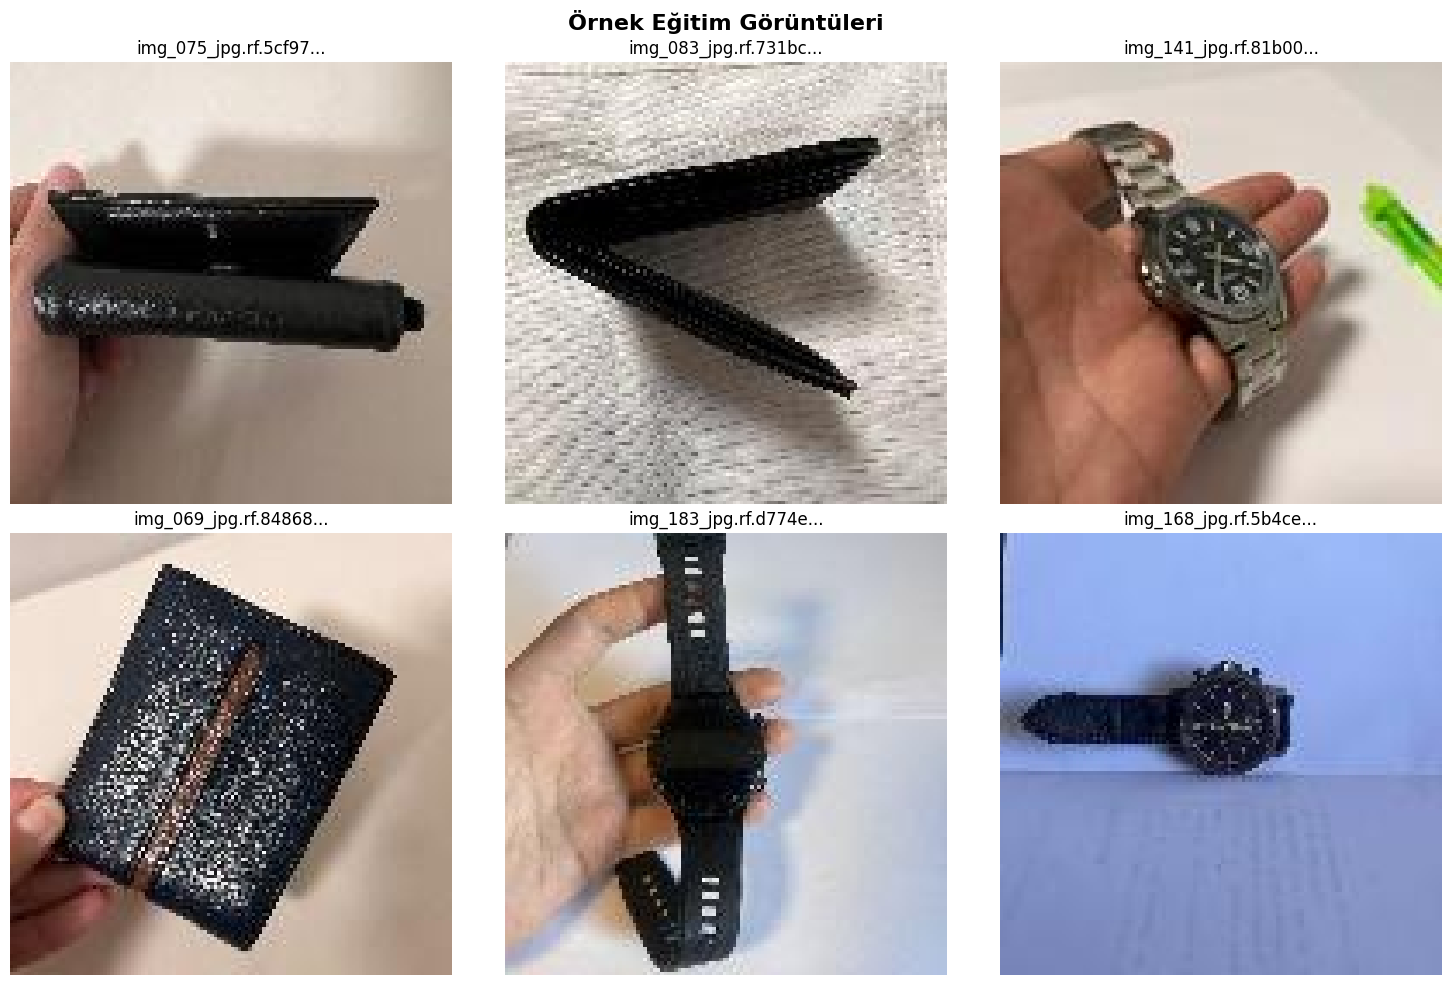


Toplam eğitim görüntüsü: 146


In [8]:
# Örnek görüntüleri göster
train_images_path = data_config['train']

if os.path.exists(train_images_path):
    images = [f for f in os.listdir(train_images_path) if f.endswith(('.jpg', '.png', '.jpeg'))][:6]

    if images:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Örnek Eğitim Görüntüleri', fontsize=16, fontweight='bold')

        for idx, img_name in enumerate(images):
            img_path = os.path.join(train_images_path, img_name)
            img = mpimg.imread(img_path)

            ax = axes[idx // 3, idx % 3]
            ax.imshow(img)
            ax.set_title(img_name[:20] + '...' if len(img_name) > 20 else img_name)
            ax.axis('off')

        plt.tight_layout()
        plt.show()
        print(f"\nToplam eğitim görüntüsü: {len(os.listdir(train_images_path))}")
else:
    print(f"❌ Klasör bulunamadı: {train_images_path}")

---
## 4. YOLOv8 Model Eğitimi

### Eğitim Parametreleri:

| Parametre | Değer | Açıklama |
|-----------|-------|----------|
| Model | YOLOv8n | Nano (hızlı, hafif) |
| Epochs | 100 | Eğitim iterasyonu |
| Image Size | 640 | Girdi boyutu |
| Batch Size | 16 | Mini-batch boyutu |
| Patience | 20 | Early stopping |

In [9]:
# YOLOv8 modelini yükle (pretrained)
model = YOLO('yolov8n.pt')  # nano model - hızlı eğitim için

print("="*60)
print("YOLOv8 EĞİTİMİ BAŞLIYOR")
print("="*60)
print(f"Model: YOLOv8n (Nano)")
print(f"Veri Seti: {yaml_path}")
print("="*60)

# Eğitimi başlat
results = model.train(
    data=yaml_path,
    epochs=100,
    imgsz=640,
    batch=16,
    patience=20,  # Early stopping
    save=True,
    project='yolo_training',
    name='saat_cuzdan_model',
    exist_ok=True,
    verbose=True
)

print("\n" + "="*60)
print("✅ EĞİTİM TAMAMLANDI!")
print("="*60)

YOLOv8 EĞİTİMİ BAŞLIYOR
Model: YOLOv8n (Nano)
Veri Seti: /content/dataset/data.yaml
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=saat_cuzdan_model, nbs=64, nms=False, opset=None, optimi

---
## 5. Eğitim Sonuçları ve Metrikler

EĞİTİM GRAFİKLERİ


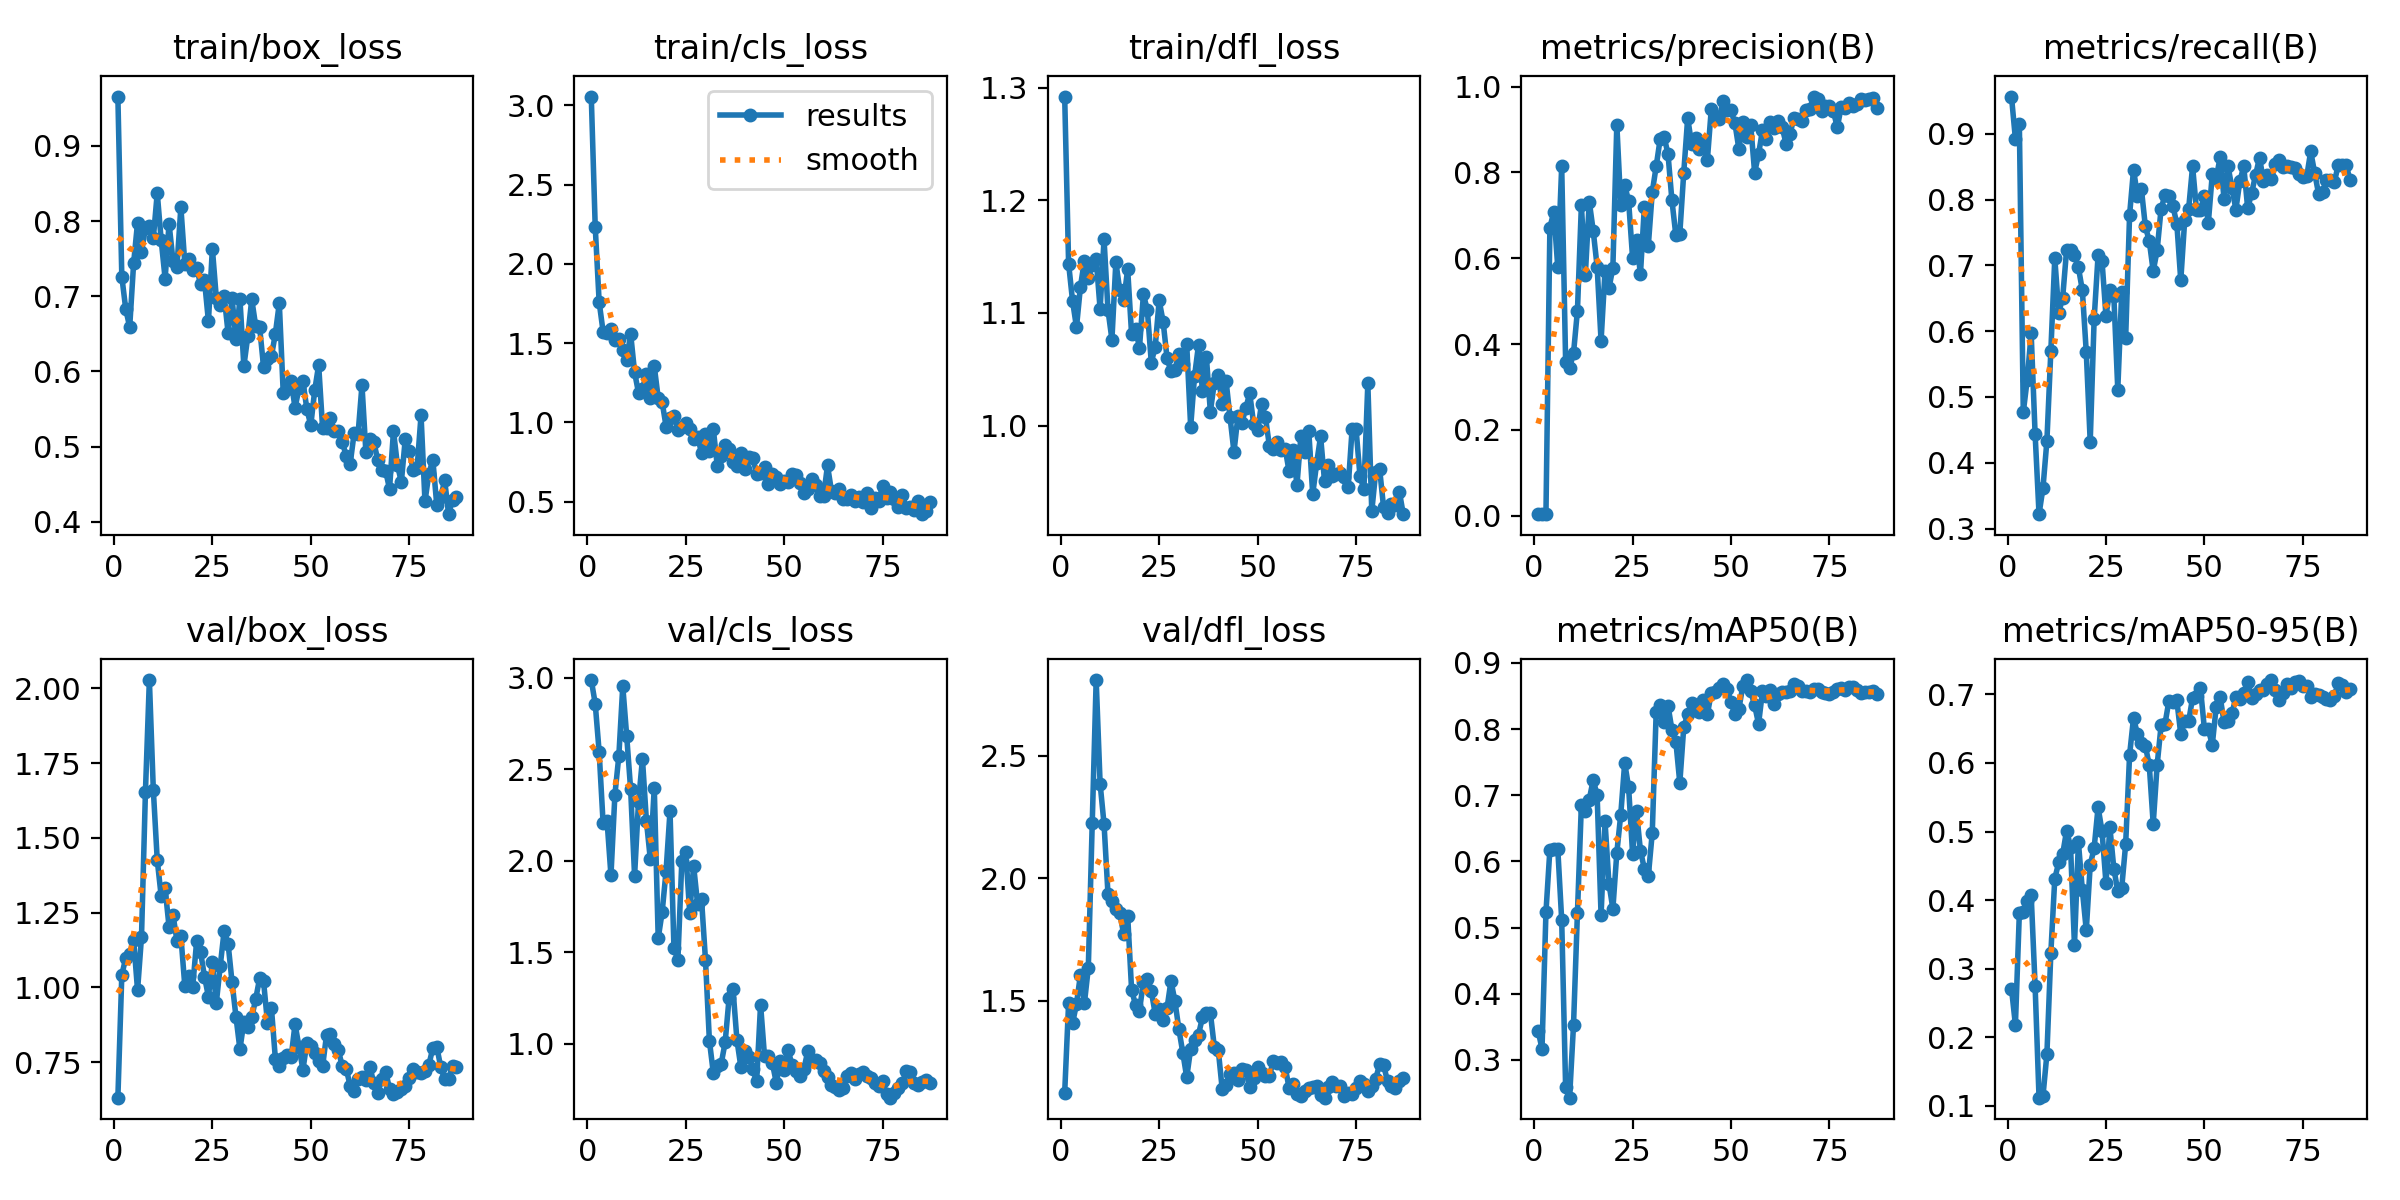

In [10]:
# Eğitim sonuçlarının bulunduğu klasör
results_dir = '/content/yolo_training/saat_cuzdan_model'

# Eğitim grafiklerini göster
print("="*60)
print("EĞİTİM GRAFİKLERİ")
print("="*60)

# results.png - tüm metrikleri içerir
results_img = os.path.join(results_dir, 'results.png')
if os.path.exists(results_img):
    display(Image(filename=results_img, width=900))
else:
    print("results.png bulunamadı")


CONFUSION MATRIX


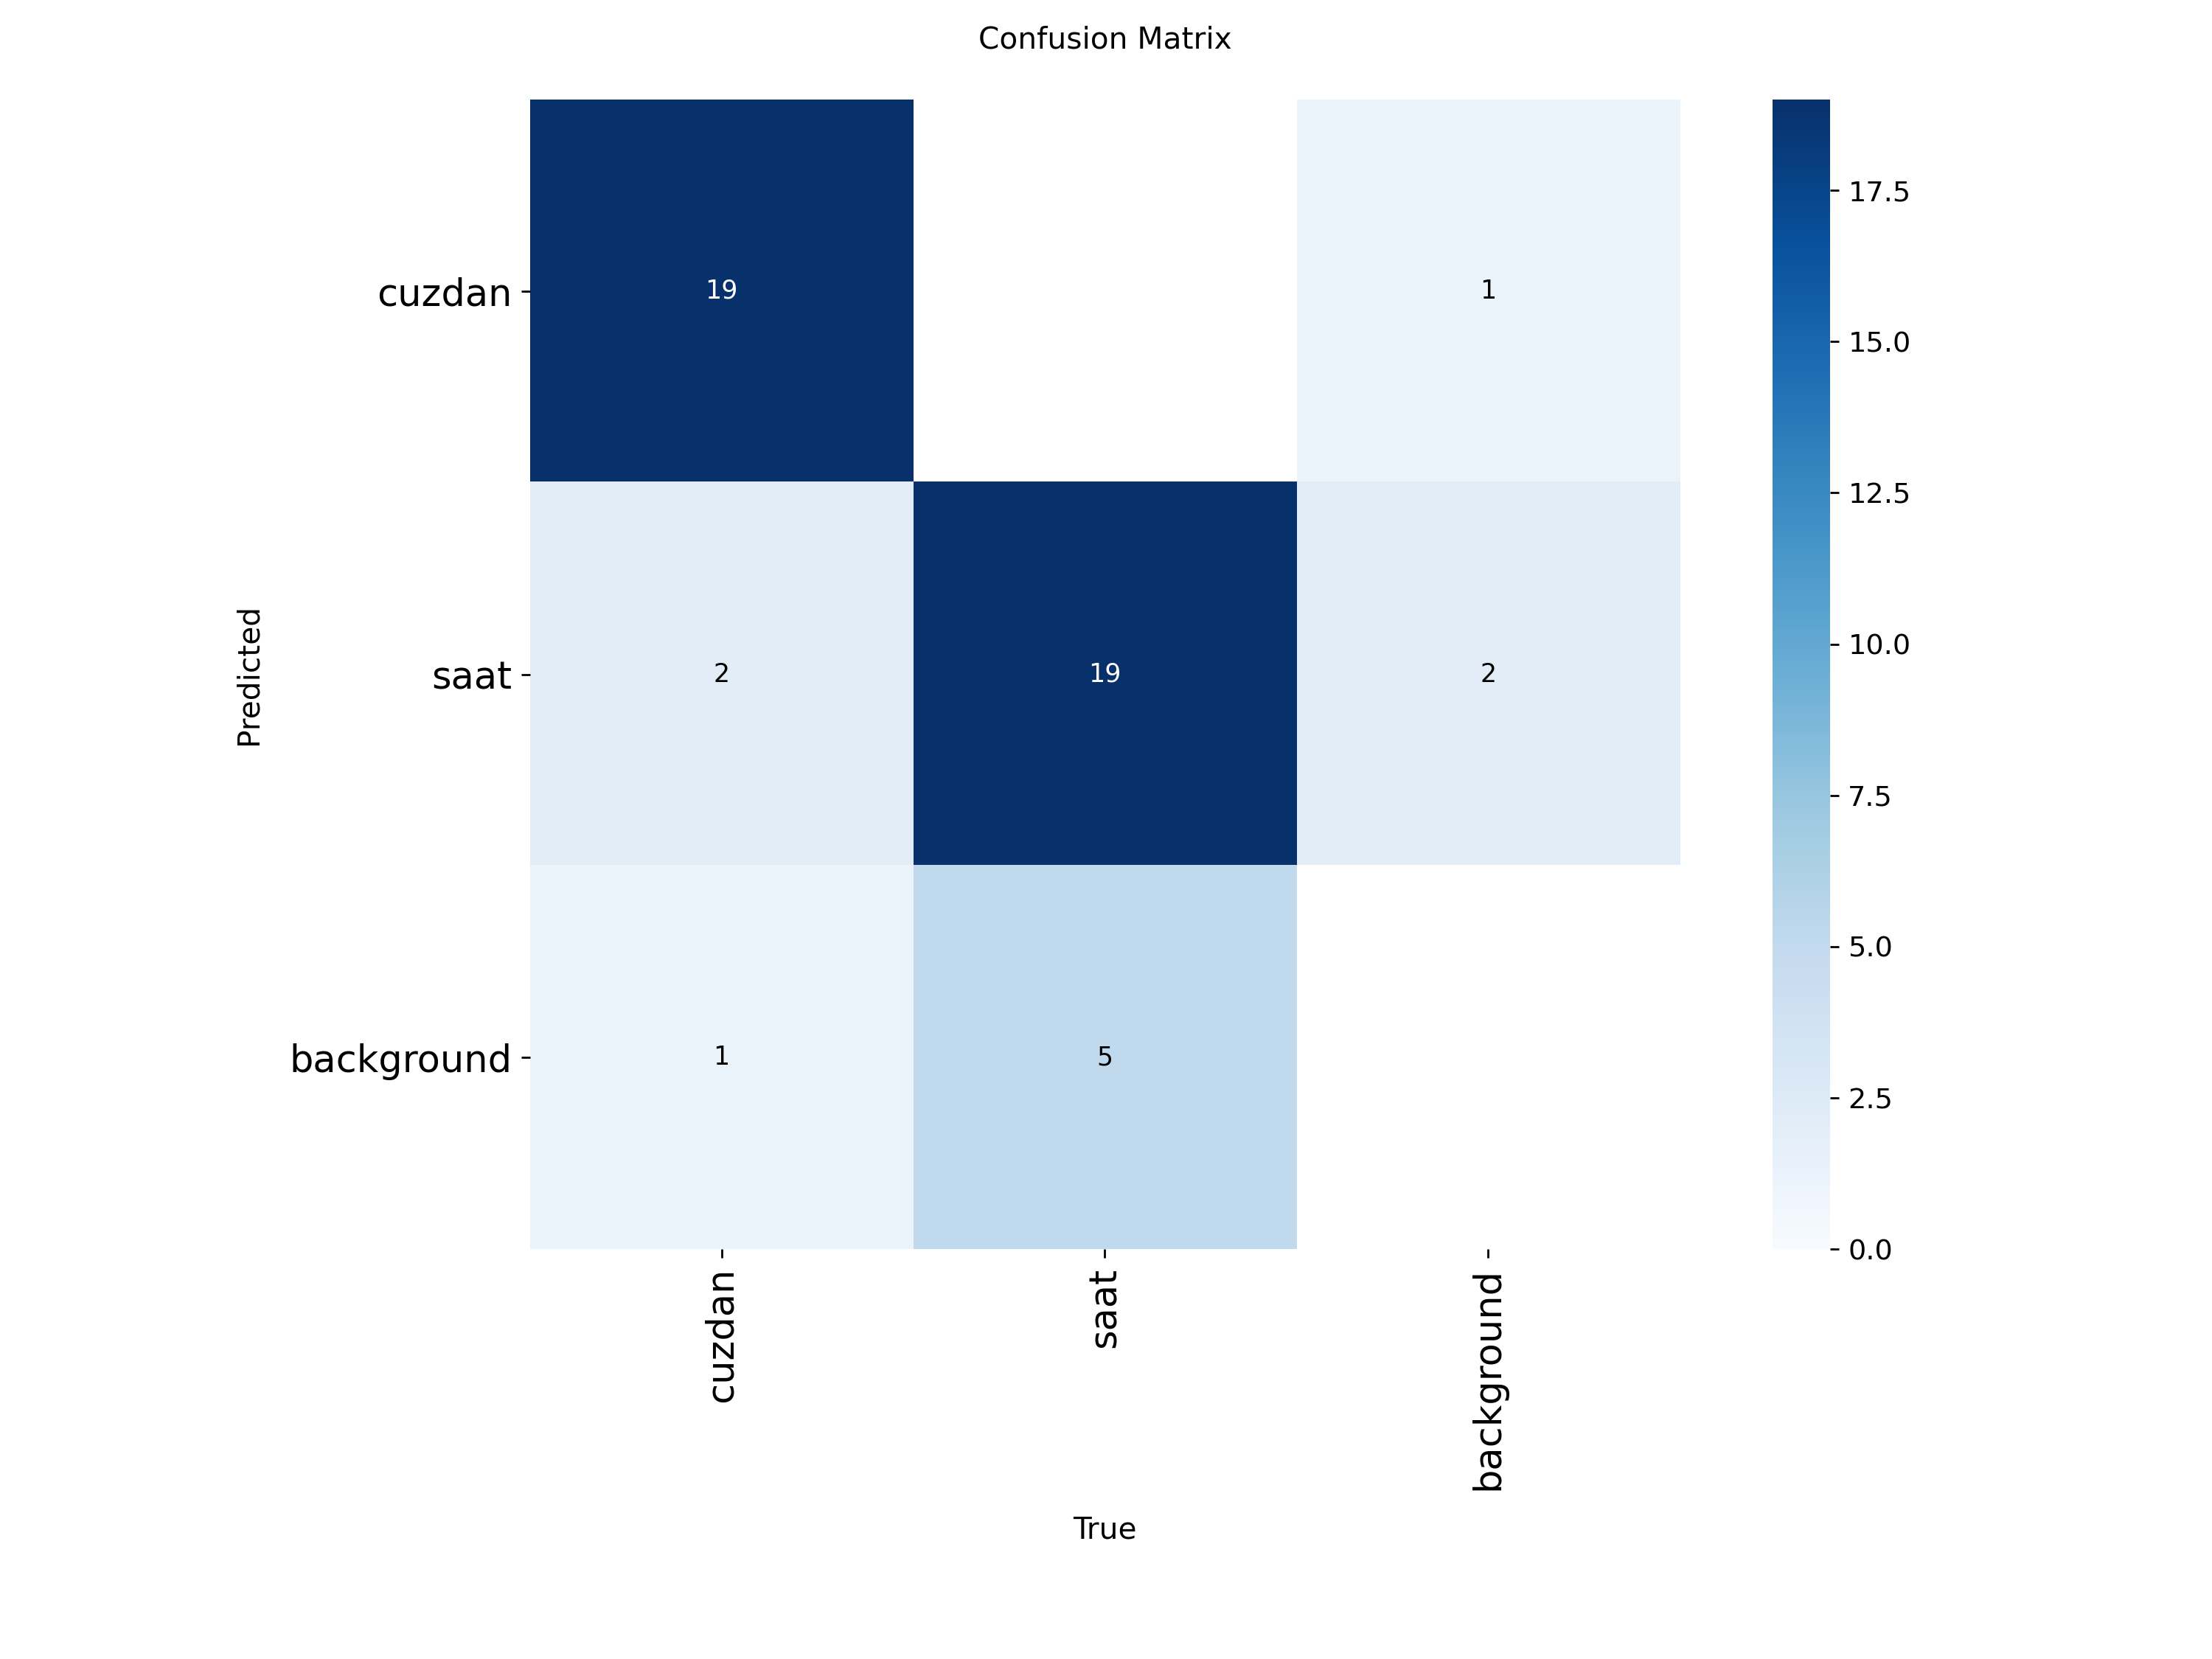

In [11]:
# Confusion Matrix
print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

cm_img = os.path.join(results_dir, 'confusion_matrix.png')
if os.path.exists(cm_img):
    display(Image(filename=cm_img, width=600))
else:
    print("confusion_matrix.png bulunamadı")

In [12]:
# Precision-Recall Curve
print("\n" + "="*60)
print("PRECISION-RECALL CURVE")
print("="*60)

pr_img = os.path.join(results_dir, 'PR_curve.png')
if os.path.exists(pr_img):
    display(Image(filename=pr_img, width=600))
else:
    print("PR_curve.png bulunamadı")


PRECISION-RECALL CURVE
PR_curve.png bulunamadı



DOĞRULAMA TAHMİNLERİ


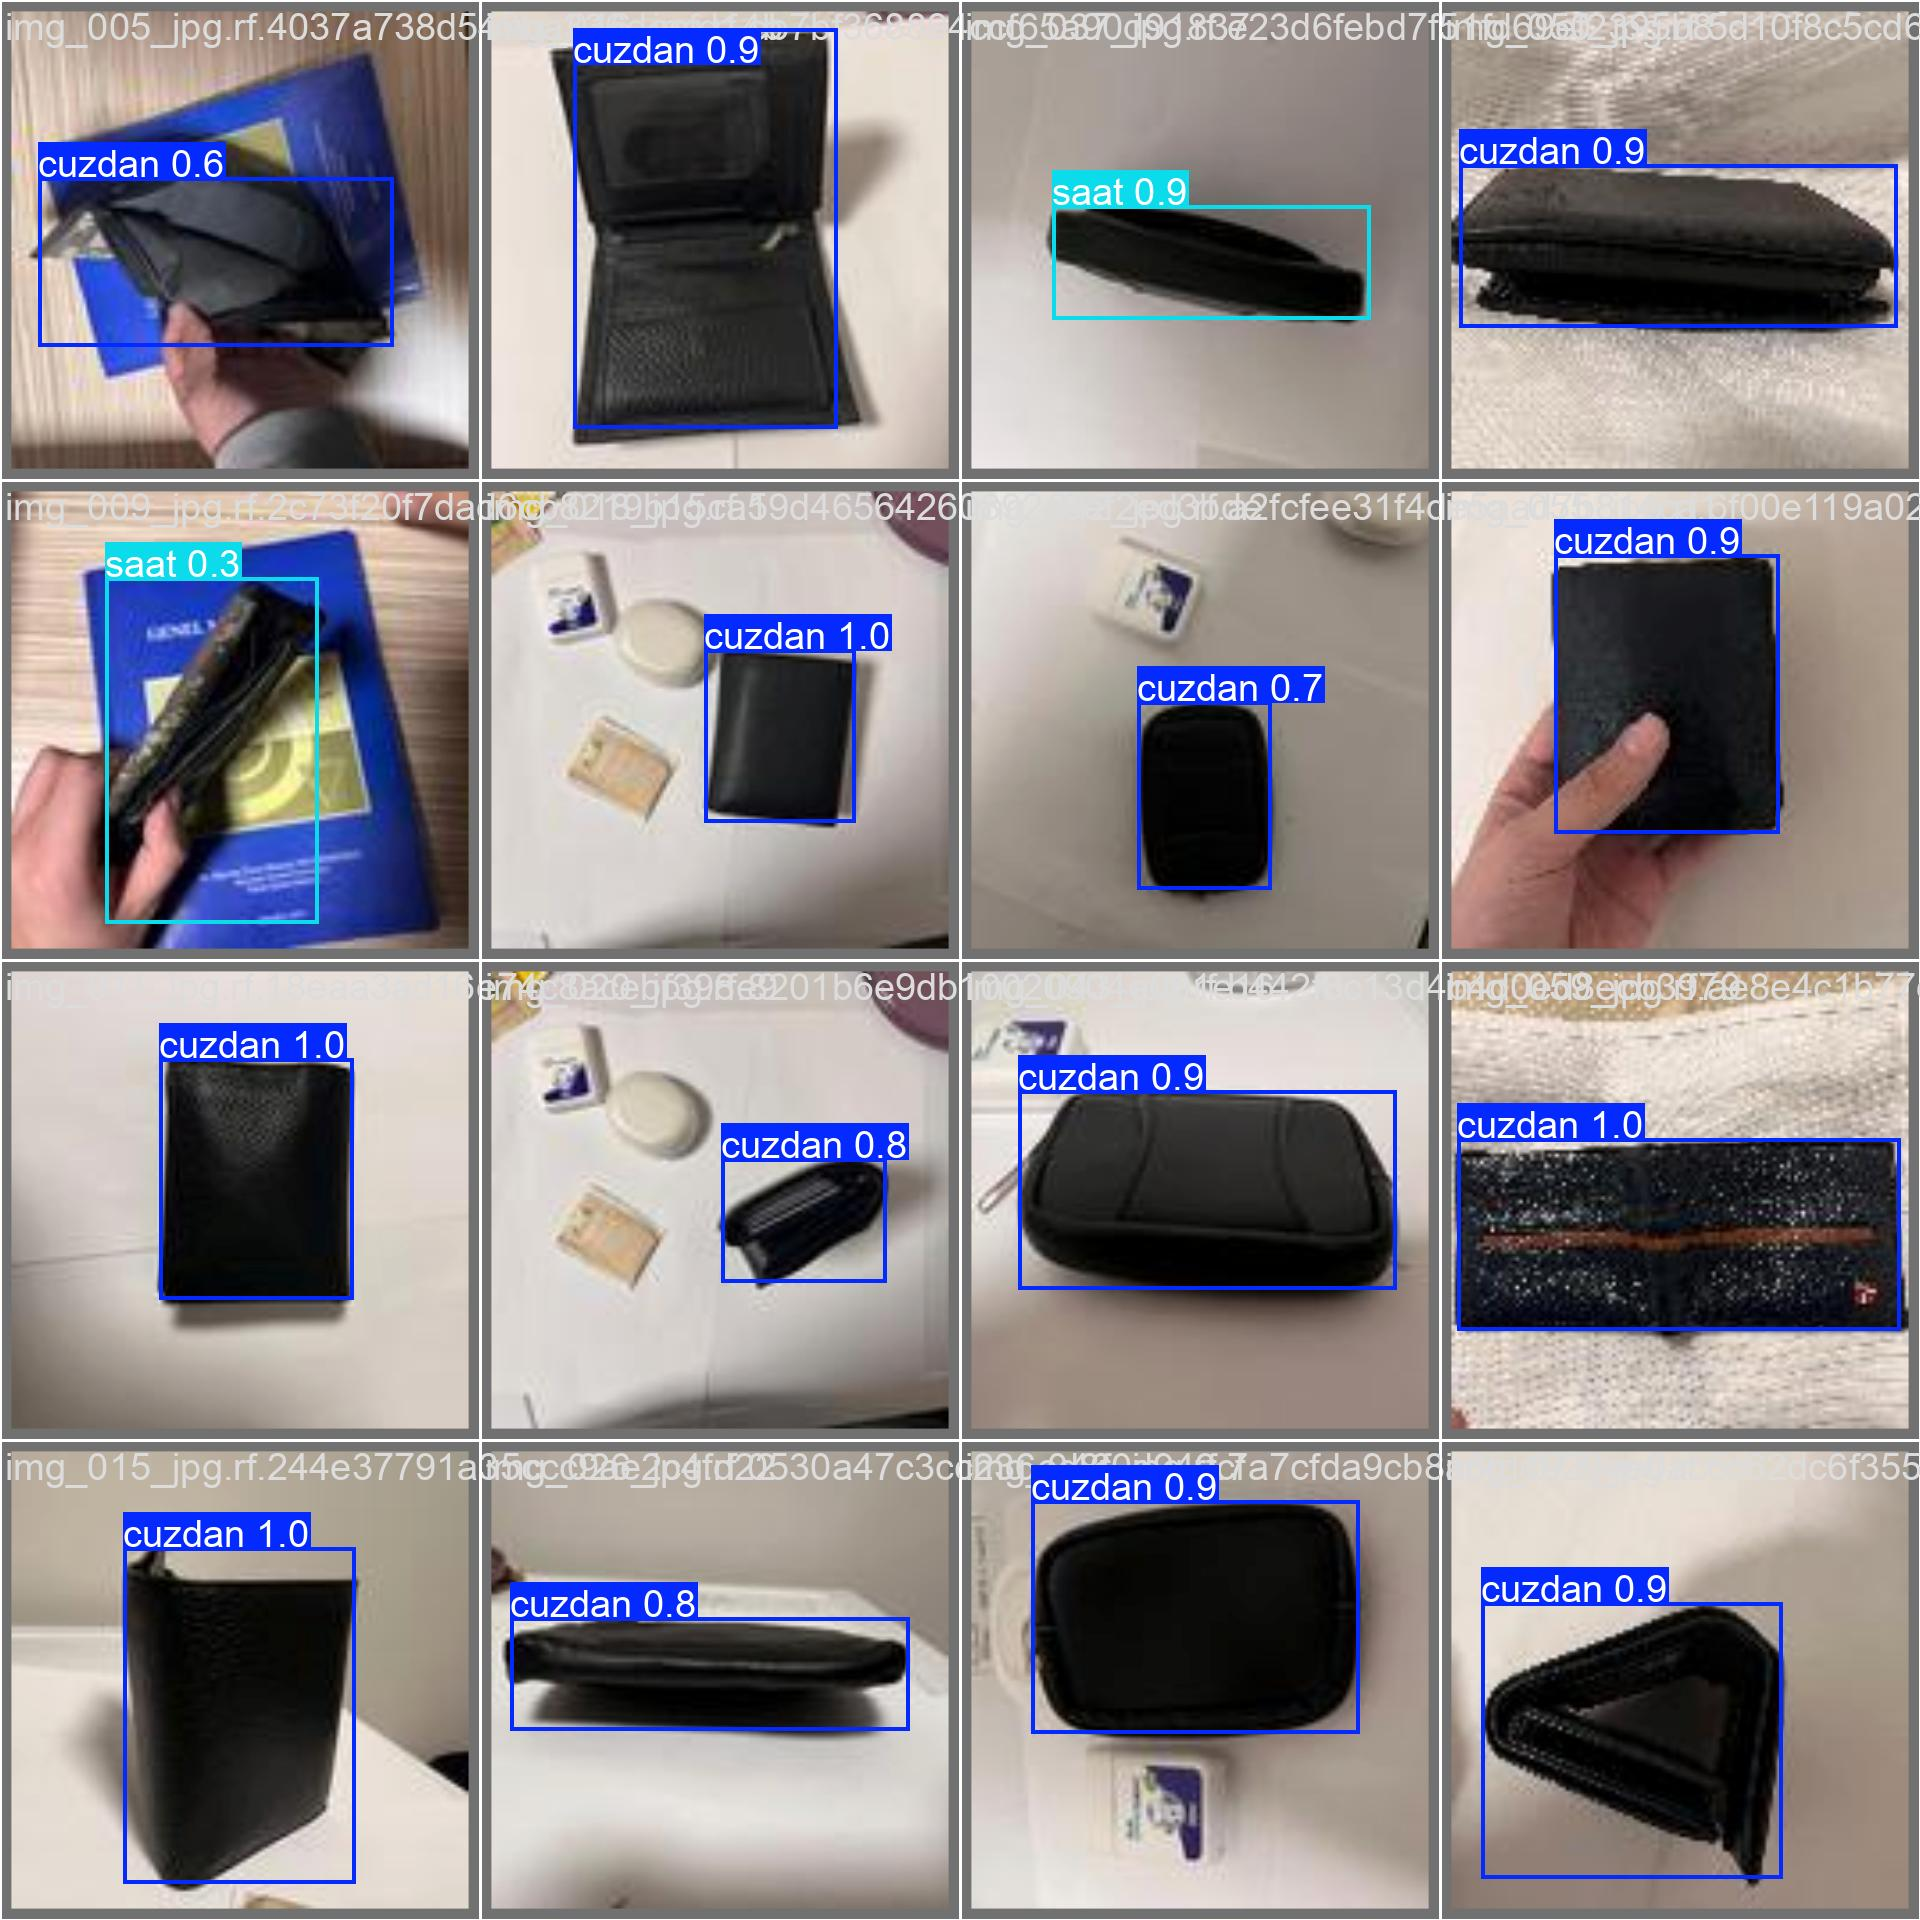

In [13]:
# Doğrulama tahminleri
print("\n" + "="*60)
print("DOĞRULAMA TAHMİNLERİ")
print("="*60)

val_pred_img = os.path.join(results_dir, 'val_batch0_pred.jpg')
if os.path.exists(val_pred_img):
    display(Image(filename=val_pred_img, width=800))
else:
    # Alternatif dosya adı dene
    for f in os.listdir(results_dir):
        if 'val' in f and 'pred' in f:
            display(Image(filename=os.path.join(results_dir, f), width=800))
            break

---
## 6. Model Değerlendirmesi (Test Seti)

In [14]:
# En iyi modeli yükle
best_model_path = os.path.join(results_dir, 'weights', 'best.pt')

if os.path.exists(best_model_path):
    print(f"✅ Best model bulundu: {best_model_path}")

    # Modeli yükle
    best_model = YOLO(best_model_path)

    # Test seti üzerinde değerlendir
    print("\n" + "="*60)
    print("TEST SETİ DEĞERLENDİRMESİ")
    print("="*60)

    metrics = best_model.val(data=yaml_path, split='test')

    print("\n" + "="*60)
    print("SONUÇ METRİKLERİ")
    print("="*60)
    print(f"mAP50: {metrics.box.map50:.4f}")
    print(f"mAP50-95: {metrics.box.map:.4f}")
    print(f"Precision: {metrics.box.mp:.4f}")
    print(f"Recall: {metrics.box.mr:.4f}")
    print("="*60)
else:
    print(f"❌ Model bulunamadı: {best_model_path}")

✅ Best model bulundu: /content/yolo_training/saat_cuzdan_model/weights/best.pt

TEST SETİ DEĞERLENDİRMESİ
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 153.9±45.8 MB/s, size: 2.8 KB)
val: Scanning /content/dataset/test/labels... 21 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 21/21 1.8Kit/s 0.0s
val: /content/dataset/test/images/img_088_jpg.rf.61f6bd7bece0b011fc24c5ac8228f957.jpg: 1 duplicate labels removed
val: New cache created: /content/dataset/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 2.7it/s 0.7s
                   all         21         23      0.901      0.925      0.933      0.753
                cuzdan          7          7          1      0.975      0.995       0.85
                  saat         14         16      0.8

---
## 7. Örnek Tahminler

TEST GÖRÜNTÜLERİ ÜZERİNDE TAHMİN

image 1/1 /content/dataset/test/images/img_051_jpg.rf.683f7edcc8ccf74f55740a0f2da5a22c.jpg: 640x640 1 cuzdan, 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/predictions/test

📷 img_051_jpg.rf.683f7edcc8ccf74f55740a0f2da5a22c.jpg
   → cuzdan: %90.9

image 1/1 /content/dataset/test/images/img_184_jpg.rf.7a588734af99e27557e065dfa13dfd2a.jpg: 640x640 2 saats, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/predictions/test

📷 img_184_jpg.rf.7a588734af99e27557e065dfa13dfd2a.jpg
   → saat: %52.8
   → saat: %51.3

image 1/1 /content/dataset/test/images/img_045_jpg.rf.2df00380f6af08ff79281c6b7576b68b.jpg: 640x640 1 cuzdan, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/predictions/test

📷 img_045_jpg.rf.2df00380f6af08ff792

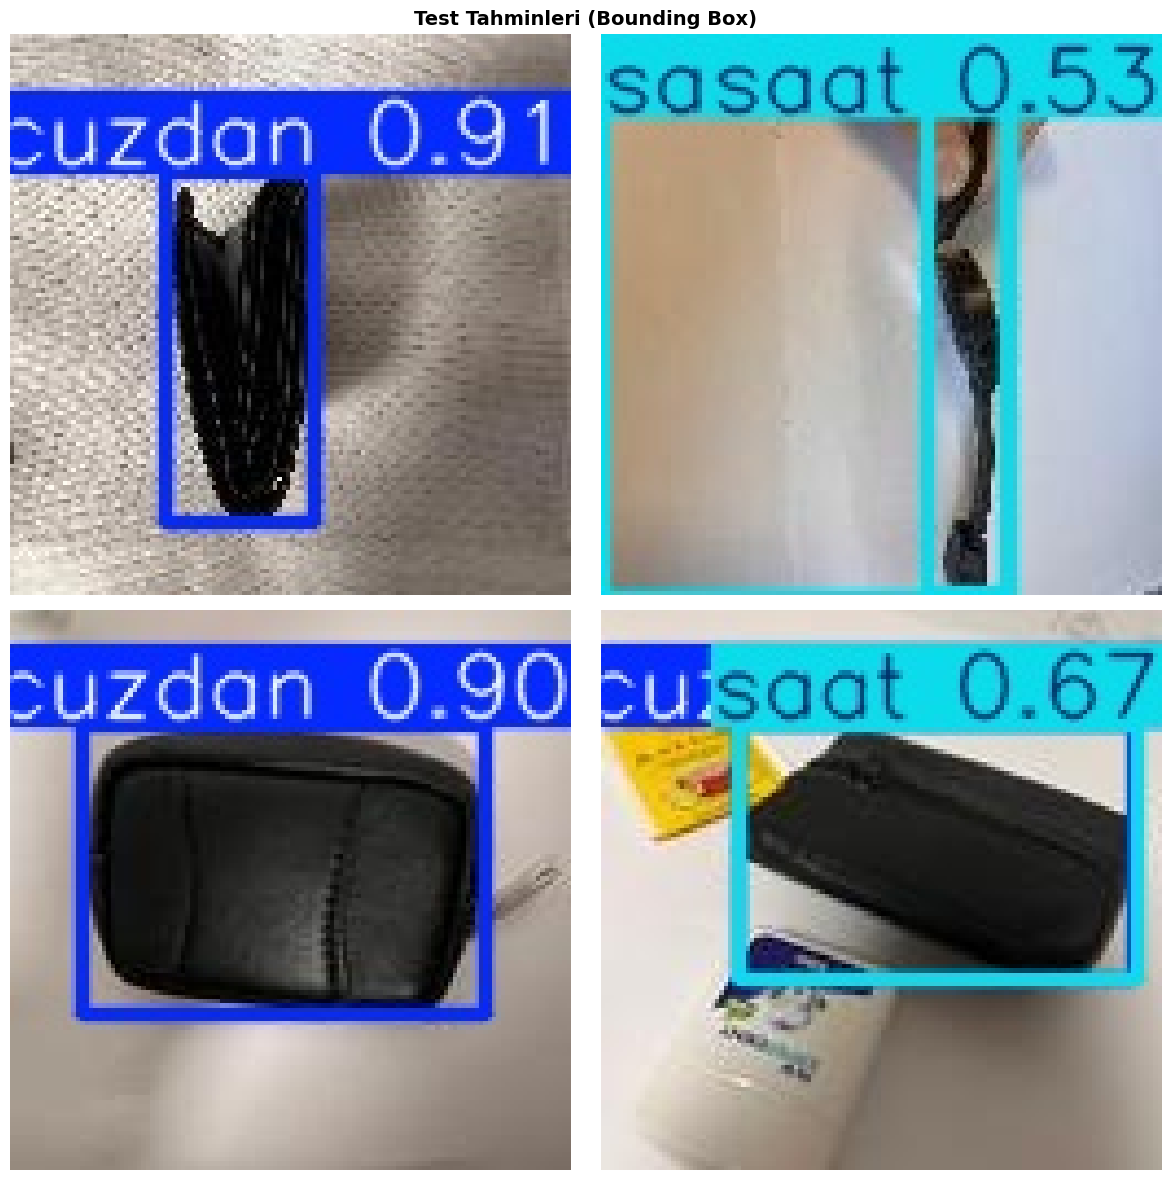

In [15]:
# Test görüntüleri üzerinde tahmin yap
test_images_path = data_config['test']

if os.path.exists(test_images_path):
    test_images = [f for f in os.listdir(test_images_path) if f.endswith(('.jpg', '.png', '.jpeg'))][:4]

    print("="*60)
    print("TEST GÖRÜNTÜLERİ ÜZERİNDE TAHMİN")
    print("="*60)

    for img_name in test_images:
        img_path = os.path.join(test_images_path, img_name)

        # Tahmin yap
        results = best_model.predict(img_path, save=True, project='predictions', name='test', exist_ok=True)

        # Sonuçları göster
        print(f"\n📷 {img_name}")
        for r in results:
            for box in r.boxes:
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])
                cls_name = data_config['names'][cls_id]
                print(f"   → {cls_name}: %{conf*100:.1f}")

    # Tahmin görüntülerini göster
    pred_dir = '/content/predictions/test'
    if os.path.exists(pred_dir):
        pred_images = [f for f in os.listdir(pred_dir) if f.endswith(('.jpg', '.png'))][:4]

        fig, axes = plt.subplots(2, 2, figsize=(12, 12))
        fig.suptitle('Test Tahminleri (Bounding Box)', fontsize=14, fontweight='bold')

        for idx, img_name in enumerate(pred_images):
            img = mpimg.imread(os.path.join(pred_dir, img_name))
            ax = axes[idx // 2, idx % 2]
            ax.imshow(img)
            ax.axis('off')

        plt.tight_layout()
        plt.savefig('test_predictions.png', dpi=150)
        plt.show()
else:
    print(f"❌ Test klasörü bulunamadı: {test_images_path}")

---
## 8. Model Dışa Aktarma

In [16]:
# best.pt dosyasını Google Drive'a kopyala
drive_output = '/content/drive/MyDrive/YoloV8_Nesne_Tespiti'
os.makedirs(drive_output, exist_ok=True)

# Model dosyasını kopyala
if os.path.exists(best_model_path):
    shutil.copy(best_model_path, os.path.join(drive_output, 'best.pt'))
    print(f"✅ best.pt kopyalandı: {drive_output}/best.pt")

# Eğitim sonuçlarını da kopyala
results_to_copy = ['results.png', 'confusion_matrix.png', 'PR_curve.png']
for fname in results_to_copy:
    src = os.path.join(results_dir, fname)
    if os.path.exists(src):
        shutil.copy(src, os.path.join(drive_output, fname))
        print(f"✅ {fname} kopyalandı")

print("\n" + "="*60)
print("TÜM DOSYALAR GOOGLE DRIVE'A KAYDEDİLDİ!")
print(f"Konum: {drive_output}")
print("="*60)

✅ best.pt kopyalandı: /content/drive/MyDrive/YoloV8_Nesne_Tespiti/best.pt
✅ results.png kopyalandı
✅ confusion_matrix.png kopyalandı

TÜM DOSYALAR GOOGLE DRIVE'A KAYDEDİLDİ!
Konum: /content/drive/MyDrive/YoloV8_Nesne_Tespiti


---
## 9. Sonuç ve Değerlendirme

### Eğitim Özeti

| Parametre | Değer |
|-----------|-------|
| Model | YOLOv8n |
| Veri Seti | 209 görüntü |
| Sınıflar | cuzdan, saat |
| Epochs | 100 (Early Stopping) |
| mAP50 | (Eğitim sonrası güncellenecek) |

---
*Halil İbrahim Balık - 2212721046 - BLG 407*